# Overview

Using Sentinal (SentinalHub) data and ML pipeline to classify landcover

1. Explore data
2. Label data by merging NARCAN land class dataset with Sentinal data (rasters)
    - Each pixel should end up with a feature set (sentinal data) and a label (NARCAN class data)
3. Train & Test model
4. Iterate

# Steps

## Data Collection

Get Sentinal-2 extent:
1. Using their visual product (EO) to find extent
2. Download raw as tiff for any gis (Q or Arc)

When merging data ensure the same **projection** of `WGS48` (Sentinal data is in this projection):
1. in the overall *project* 
2. NRCAN set
    - only apply to a *clipped* area of interest since transformations are taxing
    - nearest neighbor
    
Change resolution of both layers to match (save as -> set resolution)

Use python package to read geotiff to dataframes

### Classification

NARCAN classes:

Value 1, Temperate or sub-polar needleleaf forest, RGB 0 0.24 0;   
Value 2, Sub-polar taiga needleleaf forest, RGB 0.58 0.61 0.44;  
Value 3, Tropical or sub-tropical broadleaf evergreen forest [Does not occur]  
Value 4, Tropical or sub-tropical broadleaf deciduous forest  [Does not occur]  
Value 5, Temperate or sub-polar broadleaf deciduous forest, RGB 0.08 0.55 0.24;   
Value 6, Mixed forest, RGB 0.36 0.46 0.17;   
Value 7, Tropical or sub-tropical shrubland; [Does not occur]  
Value 8, Temperate or sub-polar shrubland, RGB 0.7 0.54 0.2;   
Value 9, Tropical or sub-tropical shrubland;  [Does not occur]  
Value 10, Temperate or sub-polar grassland, RGB 0.88 0.81 0.54;  
Value 11, Sub-polar or polar shrubland-lichen-moss, RGB 0.61 0.46 0.33;   
Value 12, Sub-polar or polar grassland-lichen-moss, RGB 0.73 0.83 0.56;   
Value 13, Sub-polar or polar barren-lichen-moss, RGB 0.25 0.54 0.45;   
Value 14, Wetland, RGB 0.42 0.64 0.54;  
Value 15, Cropland, RGB 0.9 0.68 0.4;  
Value 16, Barren lands, RGB 0.66 0.67 0.68;  
Value 17, Urban, RGB 0.86 0.13 0.15;  
Value 18, Water, RGB 0.3 0.44 0.64;  
Value 19, Snow and Ice, RGB 1 0.98 1.  

### Extent previews

Plot images and class value histograms to get a sense of what the data looks like for chosen extents.

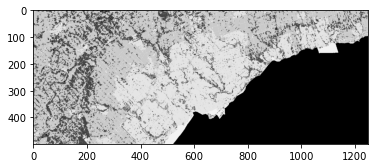

In [1]:
#test extent, edited and transformed to WGS84 via QGIS
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open('../data_tests/toronto/NRCAN_transformed.tif')
plt.imshow(im, cmap = 'gray', vmin = 0, vmax = 19)

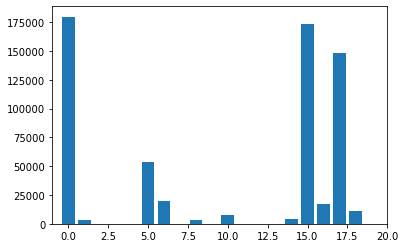

In [2]:
#function to create histogram of scenes class frequency
def nrcan_hist(img):
    import numpy as np
    import pandas as pd
    from collections import Counter

    im_array = np.array(img)

    #last line is bad values 
    im_array = im_array[:-1]

    #value count
    freq = Counter(im_array.flatten())

    plt.bar(freq.keys(), freq.values())
    plt.xlim([-1, 20])
#in this case 0 is NULL since the input image has sections without value (black areas in the water near bottom border)    
nrcan_hist(im)

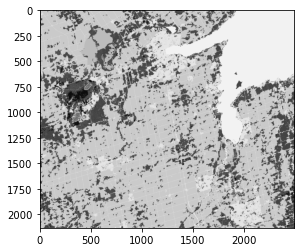

In [3]:
im2 = Image.open('../data_tests/simcoe_york/Simcoe_York_2019.tif')
plt.imshow(im2, cmap = 'gray', vmin = 0, vmax = 19)

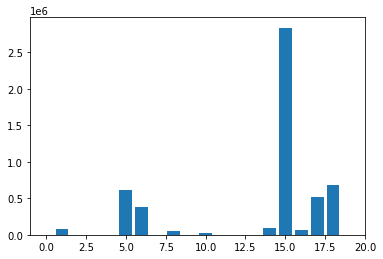

In [4]:
#different test area chosen for diverse classes
nrcan_hist(im2)

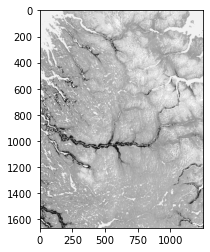

In [5]:
im3 = Image.open('../data_tests/labrador/NRCAN_transformed.tif')
plt.imshow(im3, cmap = 'gray', vmin = 0, vmax = 19)

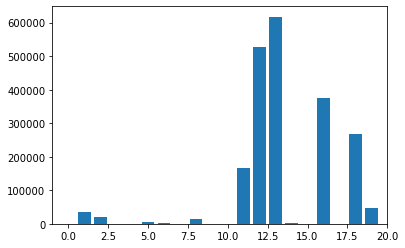

In [6]:
nrcan_hist(im3)

# Result Summary

## Overview

We started by getting multiple extents and tracking the details in a spreadsheet (see Extents.xlsx). We performed feature extraction followed by subsampling by class to train the model on balanced data. We each experimented with different feature, extent combinations and model parameters.

We used Random forest classifier from sklearn almost exclusively (there’s one exception I’ll talk about later). The hyperparameters that got the best result where train and test accuracy overlapped (no overfit) was 300 trees, max depth 15 and max features 2. I started with around 20 thousand values from each of 19 classes then slowly moved up. The final models were trained on upwards of 100 thousand values for each class. Full details on which versions used what hyperparameters and how many values per class can be found in my github land cover repo in the evaluation folder in the file ‘evaluation_legend.md’. Also, other than the first few versions I integrated [Leah’s work](https://github.com/MudSnail/Land_Cover_Classification) on calculating new layers (NDVI etc) and added at least the base 4 as features.

Important to note is that subsampling was random when pulling from different extents. Ideally when we subsampled it would pull as equal as possible from each extent, however we weren’t able to make this work. Instead the subsample is random, so each input extent is contributing a random amount to the training data for each class. A good next step for this project would be to create a way to customize how much each extent is contributing or at least track what the random subsampling is doing.

## Features

- Filtering
- K means clustering
- Edge detection
- Geocoordinates

The first feature I experimented with was **filtering**. The idea was to blur values together making any value more similar to its neighbors. Since some of the patterns we are seeing form spatial ‘clumps’, the hope was to help an unstructured model identify a pixel as being more likely to be the same as the pixel next to it. I started with gaussian filtering since it was defined as “a weighted mean of the surrounding pixels that gives more weight to the pixel near the current pixel” [CodingGame](https://www.codingame.com/playgrounds/2524/basic-image-manipulation/filtering). With just the gaussian transformation model accuracy got significantly worse, however with both gaussian and base raws the model began to ‘clump’ values more intensely (see map version 6). For most classes this created too much intensity and worsened accuracy but its performance for cropland (an intensely clumped class) is better than any model that trained without the gaussian transformed bands (see map version 11). A sub-note of that is different possible sigma values for the gaussian filtering (ie: different possible intensities). I tried 1, 3 and 5, and 5 gave the best result. The other filtering attempt was median filtering, however it was worse (see map version 7) than the gaussian filtering so eventually I just stuck to gaussian sigma 5 when using filtering as a feature.

The next feature was **clustering**. Applying k means clustering to the data to create a ‘cluster’ column with labels. This was another attempt to increase the model’s ability to clump together similar values using unsupervised learning. While I was not able to use it in a way that increased model accuracy, I still think it’s an intriguing idea with a lot of avenues. It was especially interesting to see the clusters it would identify in the demo site after having been trained on many other extents. Overall, 4 clusters seemed to give the model something (see map version 12) but didn’t do as much in identifying the spatial patterns as gaussian filters did so eventually I focused my efforts elsewhere.

**Edge detection** was part of an effort to increase Urban accuracy. Most of the time the urban class has a spatial pattern of many lines (roads) that are extremely fine. My hope was that canny edge detection would help identify these roads and give the model a column of True/False values as to whether a pixel was edge/not edge (roads always being edges). While it was not effective helping the Urban class like I had hoped (the roads are too fine), it did help overall with accuracy and balanced accuracy for subsequent model runs. It especially helps segment off water bodies. It’s worth noting that depending on what band you run the edge detection on with what level of intensity (sigma value), the results of the edge detection vary. The best results I got were from ‘B8A’ sigma = 3, although ‘B03’ sigma = 1 also picked up similar edges it tended to create more noise.

The final feature I tried was **geocoordinates**. Since the chance of a certain land cover appearing has a great deal to do with where it is geographically this was something I wanted to incorporate since day 1. It didn’t help as much as I thought, actually making the demo accuracy 2% worse, but definitely plays a large part in making the model more robust. With the incorporation of geocoordinates there is significantly less prediction of classes that aren’t in the demo extent, and I saw large increase in balanced accuracy and accuracy (5-10%) in various other random extents I tried. 

The last large step I took was to **overlap model predictions**. The main motivation was to overlap different versions, specifically a version that had been trained with gaussian transformations and a version that had not. The most sophisticated version of this would be to combine the prediction probabilities using a weighted average of some kind. Unfortunately I wasn’t able to get there, it just seemed like too much work coming into the final weeks. Instead, I made a function that takes a base model then updates it with the selected class from the predictions of a different model. It can take more than two models also, however more models the longer it takes since it has to generate entire predictions for each. Version 10 updated with class 15 (cropland) from version 13 performed better on various random extents - including the demo extent - than either model individually. 

The next piece was to make **binary models** targeting specific classes. Since the multiclass model seems completely unable to pick up the Wetland pattern in the demo extent on its own (see all map versions). I created a binary model from one vs. rest for Wetland (class 14) and combined it into the model predictions as well, using it to update the wetland class. I tried both random forest and xgboost to make this binary model. With xgboost, the three models combined performed better on all 3 extents I tried than just version 10 and 15 combined. I continued to use more updated versions to attempt combinations and from there got the best model  in terms of demo balanced accuracy (43.04%) using a base of version 14 with xgboost binary for wetland and cropland from v. 13.